In [1]:
import warnings 
import pandas as pd
import numpy as np
import nfl_data_py as nfl
import datetime as dt
import copy
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)
# Suppress FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning)


# Background/Ideas

- Features will be based off seasonal,weekly, and career based values
- Idea is that certain players which can be differentiated by career based values paired with weekly performance and or seasonal (team strength proxy) can be paired to build something relatively predictive.
- Interactivity can be dependent on clicking and choosing assortment of players and identifying/projecting current projections.
- Data seems to get updated weekly so these predictions would change over time as well.

# Data

This section focuses on pulling the data and prepping/aggregating the dependent variable. (Fantasy Points)

In [2]:
roster_data = nfl.import_seasonal_rosters([2024,2023,2022,2021,2020,2019,2018,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008,2007,2006,2005,2004,2003,2002,2001,2000,1999])
pbp_df = pd.DataFrame(nfl.import_pbp_data([2024,2023,2022,2021,2020,2019,2018,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008,2007,2006,2005,2004,2003,2002,2001,2000,1999]))
weekly_df = pd.DataFrame(nfl.import_weekly_data([2024,2023,2022,2021,2020,2019,2018,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008,2007,2006,2005,2004,2003,2002,2001,2000,1999]))
# injuries_df = pd.DataFrame(nfl.import_injuries([2024,2023,2022,2021,2020,2019,2018,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008,2007,2006,2005,2004,2003,2002,2001,2000]))
schedules_df = pd.DataFrame(nfl.import_schedules([2024,2023,2022,2021,2020,2019,2018,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008,2007,2006,2005,2004,2003,2002,2001,2000,1999]))

2024 done.
2023 done.
2022 done.
2021 done.
2020 done.
2019 done.
2018 done.
2017 done.
2016 done.
2015 done.
2014 done.
2013 done.
2012 done.
2011 done.
2010 done.
2009 done.
2008 done.
2007 done.
2006 done.
2005 done.
2004 done.
2003 done.
2002 done.
2001 done.
2000 done.
<urlopen error [WinError 10060] A connection attempt failed because the connected party did not properly respond after a period of time, or established connection failed because connected host has failed to respond>
Data not available for 1999
Downcasting floats.
Downcasting floats.


In [3]:
def get_opposing_team(df):
    if df['home_team'] == df['team']:
        val = df['away_team']
    elif df['away_team'] == df['team']:
        val = df['home_team']
    else:
        val = None

    return val


kicker_plays = pbp_df[pbp_df['kicker_player_name'].notnull()]

# kicker_plays['kicking_against_team'] = kicker_plays.apply(get_kicker_opposition,axis = 1)

# Filter out only successful field goals for longest field goal calculation

made_field_goals = kicker_plays[kicker_plays['field_goal_result'] == 'made']


## <40

kicker_plays['sub_40_fg_make'] = kicker_plays.apply(lambda row: np.where((row['field_goal_result'] == 'made') & (row['kick_distance'] < 40) , 1, 0), axis = 1)
kicker_plays['sub_40_fg_attempt'] = kicker_plays.apply(lambda row: np.where((row['field_goal_result'] != None) & (row['kick_distance'] < 40) , 1, 0), axis = 1)

## 40-49

kicker_plays['40_49_fg_make'] = kicker_plays.apply(lambda row: np.where((row['field_goal_result'] == 'made') & (row['kick_distance']  >= 40)  & (row['kick_distance'] < 50), 1, 0), axis = 1)
kicker_plays['40_49_fg_attempt'] = kicker_plays.apply(lambda row: np.where((row['field_goal_result']!= None) & (row['kick_distance']  >= 40)  & (row['kick_distance'] < 50), 1, 0), axis = 1)


## 50+ 

kicker_plays['50_fg_make'] = kicker_plays.apply(lambda row: np.where((row['field_goal_result'] == 'made') & (row['kick_distance']  >= 50), 1, 0), axis = 1)
kicker_plays['50_fg_attempt'] = kicker_plays.apply(lambda row: np.where((row['field_goal_result']!= None) & (row['kick_distance']  >= 50), 1, 0), axis = 1)





kicker_stats = kicker_plays.groupby(['game_id', 'game_date', 'week', 'season','div_game', 'home_team', 'away_team', 'weather', 'location', 'stadium',  'spread_line', 'total_line', 'roof', 'surface', 'temp', 'wind', 'home_coach', 'away_coach','kicker_player_id', 'kicker_player_name']).agg({
    'field_goal_result': lambda x: (x == 'made').sum(),  # Sum of successful field goals
    'extra_point_result': lambda x: (x == 'good').sum(),  # Sum of successful extra points
    'kick_distance': 'sum',  # Sum of kickoff yardage
    'field_goal_attempt': 'sum',  # Total field goal attempts
    'kickoff_attempt': 'sum',
    'extra_point_attempt' : 'sum',
    'sub_40_fg_make':'sum',
    'sub_40_fg_attempt':'sum',
    '40_49_fg_make':'sum',
    '40_49_fg_attempt':'sum',
    '50_fg_make':'sum',
    '50_fg_attempt' : 'sum'

}).reset_index()




## Adding in the opponent team for the kicker of interest 

kicker_team = roster_data[['season','player_id','team','depth_chart_position']]

kicker_team['team'] = kicker_team['team'].replace({'OAK':'LV', 'STL':'LA', 'SD':'LAC','HST':'HOU', 'BLT':'BAL', 'CLV':'CLE','SL':'LA','ARZ':'ARI'})

kicker_team.rename(columns = {'player_id':'kicker_player_id'},inplace = True)

kicker_stats = kicker_stats.merge(kicker_team, on = ['kicker_player_id','season'], how = 'inner')


# Calculate longest successful field goal using the filtered made_field_goals DataFrame
longest_fg = made_field_goals.groupby(['game_id','kicker_player_id', 'kicker_player_name'])['kick_distance'].max().reset_index()
longest_fg.rename(columns={'kick_distance': 'longest_fg'}, inplace=True)
# Merge longest field goal into kicker_stats
kicker_stats = pd.merge(kicker_stats, longest_fg, on=['game_id', 'kicker_player_id', 'kicker_player_name'], how='left')

# Rename the aggregated columns for clarity
kicker_stats.rename(columns={
    'field_goal_attempt': 'fg_attempts',
    'field_goal_result': 'fg_made',
    'longest_fg': 'longest_fg',
    'extra_point_result': 'xp_made',
    'extra_point_attempt': 'xp_attempts',
    'kick_distance': 'total_kick_distance'
}, inplace=True)

kicker_stats.drop(columns=['kicker_player_name'], inplace=True)

## Aggregate average score to opposition 

kicker_stats['opponent_team'] = kicker_stats.apply(get_opposing_team,axis = 1)



C:\Users\kenny\AppData\Local\Temp\ipykernel_2296\1684507005.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kicker_plays['sub_40_fg_make'] = kicker_plays.apply(lambda row: np.where((row['field_goal_result'] == 'made') & (row['kick_distance'] < 40) , 1, 0), axis = 1)
C:\Users\kenny\AppData\Local\Temp\ipykernel_2296\1684507005.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kicker_plays['sub_40_fg_attempt'] = kicker_plays.apply(lambda row: np.where((row['field_goal_result'] != None) & (row['kick_dis

In [4]:
kicker_stats[kicker_stats['opponent_team'].isna()][['game_id','team','home_team','away_team','opponent_team','season','kicker_player_id']]

,game_id,team,home_team,away_team,opponent_team,season,kicker_player_id
492,2001_12_SD_SEA,BUF,SEA,LAC,None,2001,00-0002975
494,2001_13_SD_PHI,BUF,PHI,LAC,None,2001,00-0002975
496,2001_14_OAK_SD,BUF,LAC,LV,None,2001,00-0002975
498,2001_15_SD_KC,BUF,KC,LAC,None,2001,00-0002975
500,2001_16_SEA_SD,BUF,LAC,SEA,None,2001,00-0002975
...,...,...,...,...,...,...,...
10162,2022_16_CIN_NE,DAL,NE,CIN,None,2022,00-0034909
10454,2023_04_DET_GB,CLE,GB,DET,None,2023,00-0036816
10455,2023_06_DET_TB,CLE,TB,DET,None,2023,00-0036816
10456,2023_07_DET_BAL,CLE,BAL,DET,None,2023,00-0036816


## Basic Kicking Related Variables

In [5]:

# 5 pts per 50+ yard FG made
# 4 pts per 40-49 yard FG made
# 3 pts per FG made, 39 yards or less

def get_opposing_team(df):
    if df['home_team'] == df['team']:
        val = df['away_team']
    elif df['away_team'] == df['team']:
        val = df['home_team']
    else:
        val = None

    return val


kicker_plays = pbp_df[pbp_df['kicker_player_name'].notnull()]

# kicker_plays['kicking_against_team'] = kicker_plays.apply(get_kicker_opposition,axis = 1)

# Filter out only successful field goals for longest field goal calculation

made_field_goals = kicker_plays[kicker_plays['field_goal_result'] == 'made']


## <40

kicker_plays['sub_40_fg_make'] = kicker_plays.apply(lambda row: np.where((row['field_goal_result'] == 'made') & (row['kick_distance'] < 40) , 1, 0), axis = 1)
kicker_plays['sub_40_fg_attempt'] = kicker_plays.apply(lambda row: np.where((row['field_goal_result'] != None) & (row['kick_distance'] < 40) , 1, 0), axis = 1)

## 40-49

kicker_plays['40_49_fg_make'] = kicker_plays.apply(lambda row: np.where((row['field_goal_result'] == 'made') & (row['kick_distance']  >= 40)  & (row['kick_distance'] < 50), 1, 0), axis = 1)
kicker_plays['40_49_fg_attempt'] = kicker_plays.apply(lambda row: np.where((row['field_goal_result']!= None) & (row['kick_distance']  >= 40)  & (row['kick_distance'] < 50), 1, 0), axis = 1)


## 50+ 

kicker_plays['50_fg_make'] = kicker_plays.apply(lambda row: np.where((row['field_goal_result'] == 'made') & (row['kick_distance']  >= 50), 1, 0), axis = 1)
kicker_plays['50_fg_attempt'] = kicker_plays.apply(lambda row: np.where((row['field_goal_result']!= None) & (row['kick_distance']  >= 50), 1, 0), axis = 1)





kicker_stats = kicker_plays.groupby(['game_id', 'game_date', 'week', 'season','div_game', 'home_team', 'away_team', 'weather', 'location', 'stadium',  'spread_line', 'total_line', 'roof', 'surface', 'temp', 'wind', 'home_coach', 'away_coach','kicker_player_id', 'kicker_player_name']).agg({
    'field_goal_result': lambda x: (x == 'made').sum(),  # Sum of successful field goals
    'extra_point_result': lambda x: (x == 'good').sum(),  # Sum of successful extra points
    'kick_distance': 'sum',  # Sum of kickoff yardage
    'field_goal_attempt': 'sum',  # Total field goal attempts
    'kickoff_attempt': 'sum',
    'extra_point_attempt' : 'sum',
    'sub_40_fg_make':'sum',
    'sub_40_fg_attempt':'sum',
    '40_49_fg_make':'sum',
    '40_49_fg_attempt':'sum',
    '50_fg_make':'sum',
    '50_fg_attempt' : 'sum'

}).reset_index()




## Adding in the opponent team for the kicker of interest 

kicker_team = roster_data[['season','player_id','team','depth_chart_position']]

kicker_team['team'] = kicker_team['team'].replace({'OAK':'LV', 'STL':'LA', 'SD':'LAC','HST':'HOU', 'BLT':'BAL', 'CLV':'CLE','SL':'LA','ARZ':'ARI'})


kicker_team.rename(columns = {'player_id':'kicker_player_id'},inplace = True)

kicker_stats = kicker_stats.merge(kicker_team, on = ['kicker_player_id','season'], how = 'inner')


# Calculate longest successful field goal using the filtered made_field_goals DataFrame
longest_fg = made_field_goals.groupby(['game_id','kicker_player_id', 'kicker_player_name'])['kick_distance'].max().reset_index()
longest_fg.rename(columns={'kick_distance': 'longest_fg'}, inplace=True)
# Merge longest field goal into kicker_stats
kicker_stats = pd.merge(kicker_stats, longest_fg, on=['game_id', 'kicker_player_id', 'kicker_player_name'], how='left')

# Rename the aggregated columns for clarity
kicker_stats.rename(columns={
    'field_goal_attempt': 'fg_attempts',
    'field_goal_result': 'fg_made',
    'longest_fg': 'longest_fg',
    'extra_point_result': 'xp_made',
    'extra_point_attempt': 'xp_attempts',
    'kick_distance': 'total_kick_distance'
}, inplace=True)

kicker_stats.drop(columns=['kicker_player_name'], inplace=True)

## Aggregate average score to opposition 

kicker_stats['opponent_team'] = kicker_stats.apply(get_opposing_team,axis = 1)

print('Number Missing Opponent:' + str(kicker_stats[kicker_stats['opponent_team'].isna()].shape[0]))
kicker_stats = kicker_stats[~kicker_stats['opponent_team'].isna()]

home_teams = schedules_df[['season','home_team','away_score']].copy()

away_teams = schedules_df[['season','away_team','home_score']].copy()

home_teams.rename(columns = {'home_team':'team','away_score':'points_allowed'}, inplace = True)
away_teams.rename(columns = {'away_team':'team','home_score':'points_allowed'}, inplace = True)

points_allowed_df = pd.concat([home_teams,away_teams])


points_allowed_df['avg_points_allowed'] = points_allowed_df.groupby(['season','team'])['points_allowed'].transform('mean')


points_allowed_df.rename(columns = {'team':'opponent_team'},inplace = True)


kicker_stats = kicker_stats.merge(points_allowed_df[['season','opponent_team','avg_points_allowed']].drop_duplicates(), on = ['opponent_team','season'], how = 'left')

## Creating Average Field Goals Per Game

kicker_stats['average_field_goals'] = kicker_stats.groupby(['kicker_player_id','season'])['fg_made'].transform('mean')

## Creating Field Goal Make Percentage (Seasonal)

kicker_stats['total_made'] = kicker_stats.groupby(['kicker_player_id','season'])['fg_made'].transform('sum')
kicker_stats['total_attempts'] = kicker_stats.groupby(['kicker_player_id','season'])['fg_attempts'].transform('sum')

kicker_stats['season_make_percentage_fg'] = round(kicker_stats['total_made'].astype(float) / kicker_stats['total_attempts'].astype(float),2)


## Creating Average Extra Points Per Game


kicker_stats['average_xp'] = kicker_stats.groupby(['kicker_player_id','season'])['xp_made'].transform('mean')

## Creating Extra Point Make Percentage (Seasonal)

kicker_stats['total_made_xp'] = kicker_stats.groupby(['kicker_player_id','season'])['xp_made'].transform('sum')
kicker_stats['total_attempts_xp'] = kicker_stats.groupby(['kicker_player_id','season'])['xp_attempts'].transform('sum')

kicker_stats['season_make_percentage-xp'] = round(kicker_stats['total_made_xp'].astype(float) / kicker_stats['total_attempts_xp'].astype(float),2)

for_fantasy_scoring = pbp_df[pbp_df['kicker_player_name'].notnull()]


## Game FG Make Percentage

kicker_stats['fg_make_prop'] = kicker_stats['fg_made'] / kicker_stats['fg_attempts']


## 50+ 

kicker_stats['50_make_prop'] = np.where((kicker_stats['50_fg_make'] == 0 ) & (kicker_stats['50_fg_attempt'] == 0), 0 ,kicker_stats['50_fg_make'] / kicker_stats['50_fg_attempt'])


## 40-49

kicker_stats['40_49_make_prop'] = np.where((kicker_stats['40_49_fg_make'] == 0 ) & (kicker_stats['40_49_fg_attempt'] == 0),0,kicker_stats['40_49_fg_make'] / kicker_stats['40_49_fg_attempt'])

## Sub 40 

kicker_stats['sub_40_make_prop'] = np.where((kicker_stats['sub_40_fg_make'] == 0 ) & (kicker_stats['sub_40_fg_attempt'] == 0),0,kicker_stats['sub_40_fg_make'] / kicker_stats['sub_40_fg_attempt'])



## Creating Average Extra Point Attempts (Proxy for how often Team Scores)


kicker_stats['xp_attempts_per_game'] = round(kicker_stats.groupby(['kicker_player_id','season'])['xp_attempts'].transform('mean'),2)


## Average Fantasy Points Allowed To Kickers


## scoring criteria 
# https://www.espn.com/fantasy/football/ffl/story?page=fflrulesstandardscoring

kicker_stats['total_kicking_points_fantasy'] = (kicker_stats['50_fg_make'] * 5) + (kicker_stats['40_49_fg_make'] * 4) + (kicker_stats['sub_40_fg_make'] * 3) +((kicker_stats['40_49_fg_attempt'] - kicker_stats['40_49_fg_make']) * -1) + ((kicker_stats['sub_40_fg_attempt'] - kicker_stats['sub_40_fg_make']) * -2) + (kicker_stats['xp_made'] * 1)

# .apply(lambda row: (int(row['50_fg_make']) * 5) + (row['40_49_fg_make'] * 4) + (row['sub_40_fg_make'] * 3) + ((row['fg_attempts'] - row['fg_made']) * -1)) 


kicker_stats['opp_avg_kick_points_allowed'] = kicker_stats.groupby('opponent_team')['total_kicking_points_fantasy'].transform('mean')
 

# kicker_stats['points_from_kicks'] = kicker_stats['fg_made']
# kicker_stats['points_from_xp'] = kick


C:\Users\kenny\AppData\Local\Temp\ipykernel_2296\2644166056.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kicker_plays['sub_40_fg_make'] = kicker_plays.apply(lambda row: np.where((row['field_goal_result'] == 'made') & (row['kick_distance'] < 40) , 1, 0), axis = 1)
C:\Users\kenny\AppData\Local\Temp\ipykernel_2296\2644166056.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kicker_plays['sub_40_fg_attempt'] = kicker_plays.apply(lambda row: np.where((row['field_goal_result'] != None) & (row['kick_dis

Number Missing Opponent:352


## Weather/Condition Related Variables

- Home/Away Encoding : Chirps and Energy From Home Games could increase Pressure
- Surface (One Hot Encoding): The Surface of the field is something to monitor.
- Interaction term with MPH of Wind and Make Percentage (Windier Conditions can have interaction with lower fg make percentage)

In [6]:
kicker_stats['home_away_flag'] = np.where(kicker_stats['opponent_team'] == kicker_stats['home_team'], 0,1)
kicker_stats['surface'] = kicker_stats['surface'].str.strip()
kicker_stats = kicker_stats.join(pd.get_dummies(data = kicker_stats['surface'], prefix = 'flag'))

In [7]:
## Wind MPH INteraction and Game Kicking Percentage 

kicker_stats['wind_make_interaction'] = kicker_stats['wind'] * kicker_stats['fg_make_prop']
kicker_stats['wind_make_interaction'] = kicker_stats['wind_make_interaction'].fillna(0)

## Aggregating Proportion of Scoring From Kicks

- Rationale is that if a team is showing signs of scoring mainly from Touchdowns and 2 Point Conversions kickers are likely to have less influence.
- Also if this is aggregated at the game level, interaction with wind and or other weather related factors could prove to be useful.

In [8]:
game_w_score_df = schedules_df[['away_score','home_score','home_team','away_team','game_id']].copy()
## Cleaveland and Baltimore Bug In Denotions across Schedules DF and the Rest


# game_w_score_df['home_team'] = game_w_score_df['home_team'].replace({'CLE':'CLV', 'BAL':'BLT'})
# game_w_score_df['away_team'] = game_w_score_df['away_team'].replace({'CLE':'CLV', 'BAL':'BLT'})


kicker_stats = kicker_stats.merge(game_w_score_df, how = 'inner', on = ['game_id', 'home_team','away_team'])



kicker_stats['team_actual_scored_points'] = np.where(kicker_stats['team'] == kicker_stats['home_team'], kicker_stats['home_score'],kicker_stats['away_score'])

## Filtering out bad data from incorrect schedule game result values

kicker_stats = kicker_stats[~(kicker_stats['team_actual_scored_points'] == 0) & ((kicker_stats['fg_made'] > 0) | (kicker_stats['xp_made'] > 0))]
                            

kicker_stats.drop(columns = ['home_score','away_score'],inplace = True)

## Game Level
kicker_stats['points_scored_from_kicks_prop'] = ((kicker_stats['fg_made'] * 3) + (kicker_stats['xp_made'] * 1 )) /  kicker_stats['team_actual_scored_points'] 

## Season Team Level

kicker_stats['points_scored_from_kicks_szn'] = kicker_stats.groupby(['team','season'])['points_scored_from_kicks_prop'].transform('mean') 

## Number of Games Played in Career

kicker_stats['games_played_in_career'] = kicker_stats.groupby('kicker_player_id')['game_id'].transform('count')




# Begin Modeling

In [9]:
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score,mean_absolute_error, mean_squared_error
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from math import sqrt

In [10]:
x_vars = ['div_game','spread_line','avg_points_allowed','average_field_goals','total_made','total_attempts',
          'average_xp', '50_make_prop','40_49_make_prop','sub_40_make_prop','xp_attempts_per_game',
          'opp_avg_kick_points_allowed','home_away_flag','flag_a_turf','flag_astroplay','flag_astroturf','flag_dessograss','flag_fieldturf',
          'flag_grass','flag_sportturf','wind_make_interaction','team_actual_scored_points','points_scored_from_kicks_prop','points_scored_from_kicks_szn',
          'games_played_in_career']

y_var = ['total_kicking_points_fantasy']

In [11]:
# Checking for columns with nulls that are also in x_vars
null_columns = [col for col in kicker_stats.columns if kicker_stats[col].isna().any() and col in x_vars]
display(null_columns)

[]

## Feature Selection and Model Evaluation
**Feature Selection Methods**
- Sequential Feature Selection (SFS)
- Lasso
- Elastic Net

**Model Evaluation**
- Linear Regression
- Random Forest


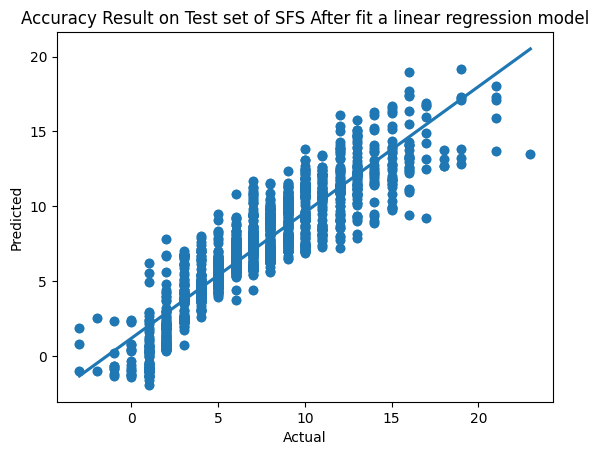

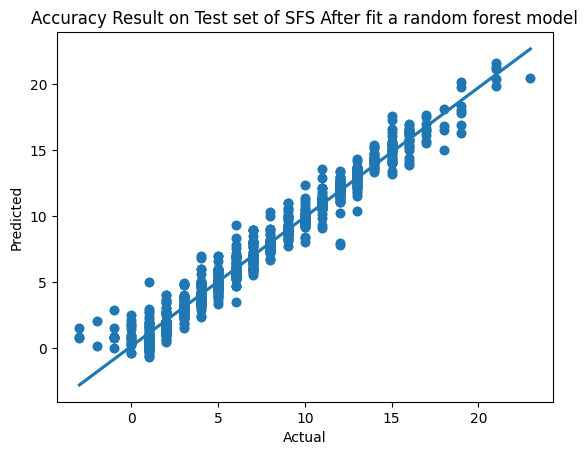

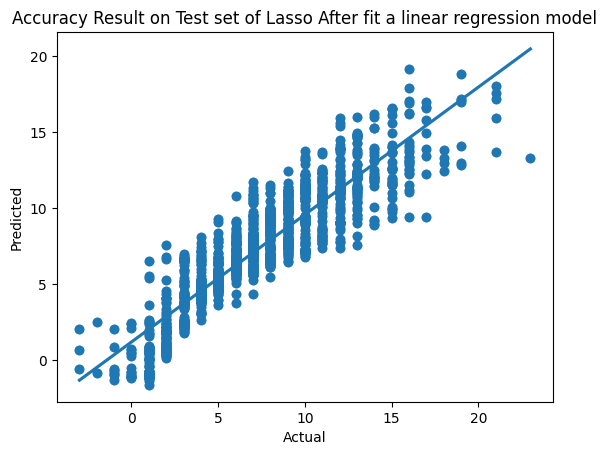

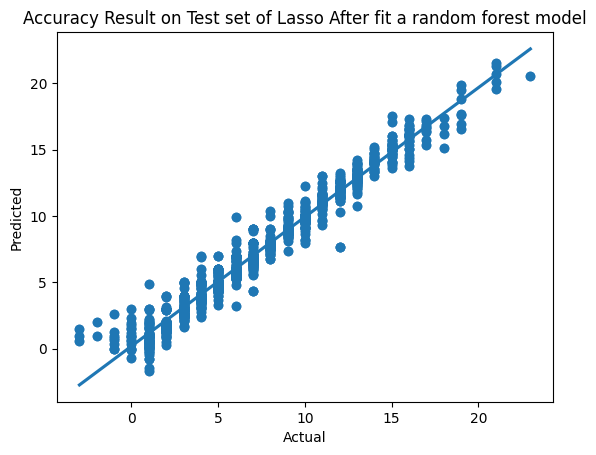

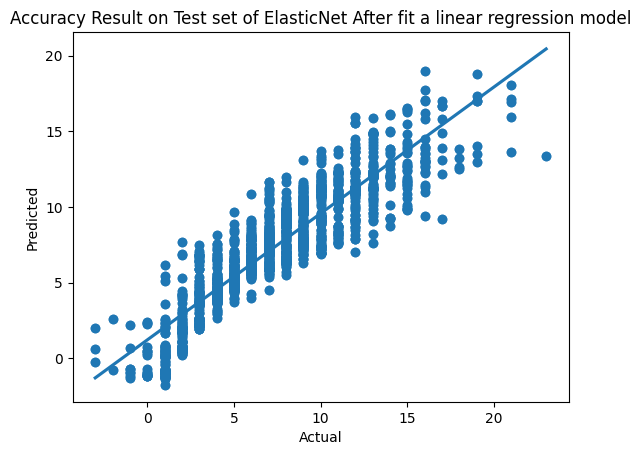

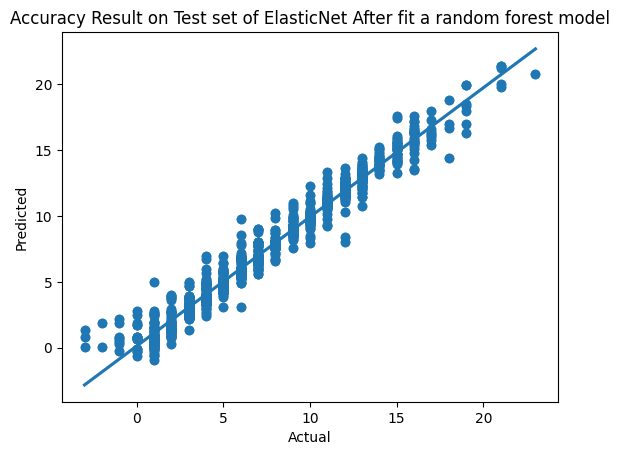

Model Evaluation Results:
       Method              Model       MAE       MSE
0         SFS  Linear Regression  1.309242  3.006810
1         SFS      Random Forest  0.423656  0.502270
2       Lasso  Linear Regression  1.315176  3.035368
3       Lasso      Random Forest  0.396004  0.502340
4  ElasticNet  Linear Regression  1.321181  3.060369
5  ElasticNet      Random Forest  0.423343  0.488127


In [12]:
# Define your dataset
X = kicker_stats[x_vars]
y = kicker_stats[y_var] 

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert y_train and y_test to 1D arrays
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

#Cast from type objet to float
Y_test = y_test.astype('float64')

# Standardize data for models that require it
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define models for evaluation
linear_model = LinearRegression()
rf_model = RandomForestRegressor(random_state=42)

# Function to evaluate model performance
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return mean_absolute_error(y_test, y_pred),  mean_squared_error(y_test, y_pred), y_pred

# Dictionary to store evaluation results
results = {'Method': [], 'Model': [], 'MAE': [], 'MSE': []}

# Feature Selection Methods
# Sequential Feature Selection (SFS)
sfs_selector = SFS(linear_model, k_features=10, forward=True, floating=False, scoring='neg_mean_absolute_error', cv=5)
sfs_selector = sfs_selector.fit(X_train, y_train)
sfs_features = list(sfs_selector.k_feature_names_)
X_train_sfs = X_train[sfs_features]
X_test_sfs = X_test[sfs_features]

# Lasso for Feature Selection
lasso_selector = Lasso(alpha=0.1, random_state=42)
lasso_selector.fit(X_train_scaled, y_train)
lasso_features = [feature for feature, coef in zip(X.columns, lasso_selector.coef_) if coef != 0]
X_train_lasso = X_train[lasso_features]
X_test_lasso = X_test[lasso_features]

# Elastic Net for Feature Selection
elastic_net_selector = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)
elastic_net_selector.fit(X_train_scaled, y_train)
elastic_net_features = [feature for feature, coef in zip(X.columns, elastic_net_selector.coef_) if coef != 0]
X_train_enet = X_train[elastic_net_features]
X_test_enet = X_test[elastic_net_features]

# Evaluate models with each feature selection method
for method, X_train_fs, X_test_fs in zip(
    ['SFS', 'Lasso', 'ElasticNet'],
    [X_train_sfs, X_train_lasso, X_train_enet],
    [X_test_sfs, X_test_lasso, X_test_enet]
):
    # Linear Regression
    mae_linear, mse_linear, y_pred1 = evaluate_model(linear_model, X_train_fs, X_test_fs, y_train, y_test)
    results['Method'].append(method)
    results['Model'].append('Linear Regression')
    results['MAE'].append(mae_linear)
    results['MSE'].append(mse_linear)
    
    #LM Regrssion Plot:
    plt.scatter(Y_test,y_pred1)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Accuracy Result on Test set of ' + method + ' After fit a linear regression model')
    sns.regplot(x=Y_test,y=y_pred1,ci=None)     
    plt.show()
    
    # Random Forest
    mae_rf, mse_rf, y_pred2 = evaluate_model(rf_model, X_train_fs, X_test_fs, y_train, y_test)
    results['Method'].append(method)
    results['Model'].append('Random Forest')
    results['MAE'].append(mae_rf)
    results['MSE'].append(mse_rf)

    #RF Regrssion Plot:
    plt.scatter(Y_test,y_pred2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Accuracy Result on Test set of ' + method + ' After fit a random forest model')
    sns.regplot(x=Y_test,y=y_pred2,ci=None)
    plt.show()

# Display results
results_df = pd.DataFrame(results)
print("Model Evaluation Results:")
print(results_df)

In [13]:
print("Selected Features (SFS):\n", sfs_features, "\n")
print("Selected Features (Lasso):\n", lasso_features, "\n")
print("Selected Features (Elastic Net):\n", elastic_net_features)

Selected Features (SFS):
 ['average_field_goals', 'average_xp', '50_make_prop', '40_49_make_prop', 'sub_40_make_prop', 'xp_attempts_per_game', 'home_away_flag', 'team_actual_scored_points', 'points_scored_from_kicks_prop', 'points_scored_from_kicks_szn'] 

Selected Features (Lasso):
 ['average_field_goals', '50_make_prop', '40_49_make_prop', 'sub_40_make_prop', 'team_actual_scored_points', 'points_scored_from_kicks_prop'] 

Selected Features (Elastic Net):
 ['avg_points_allowed', 'average_field_goals', '50_make_prop', '40_49_make_prop', 'sub_40_make_prop', 'opp_avg_kick_points_allowed', 'flag_sportturf', 'wind_make_interaction', 'team_actual_scored_points', 'points_scored_from_kicks_prop', 'points_scored_from_kicks_szn']


Random Forest consistently outperformed Linear Regression in predicting kicking performance across all feature selection methods. Among the techniques, Lasso-selected features combined with Random Forest achieved the highest accuracy. However, Elastic Net proved to be a strong option, delivering good performance while retaining more features. This could be beneficial for further analysis, as it preserves additional variables that might provide deeper insights into player and game dynamics. These results suggest that combining Elastic Net with a robust model like Random Forest can enhance both prediction accuracy and interpretability.

## First Approach Basic Stepwise For Feature Selection

In [14]:
len(x_vars)

25

In [15]:
# Initialize the Linear Regression model
clf = LinearRegression()

# Set up Step Forward Feature Selection (SFFS) with specified parameters
sfs = SFS(estimator=clf, 
          k_features=10, 
          forward=True, 
          floating=False, 
          scoring='neg_mean_absolute_error', 
          cv=5)

# Fit SFFS on the data
sfs = sfs.fit(kicker_stats[x_vars], kicker_stats[y_var])

# Extract the selected features
selected_features = list(sfs.k_feature_names_)

In [16]:
selected_features

['average_field_goals',
 'average_xp',
 '50_make_prop',
 '40_49_make_prop',
 'sub_40_make_prop',
 'xp_attempts_per_game',
 'flag_sportturf',
 'team_actual_scored_points',
 'points_scored_from_kicks_prop',
 'points_scored_from_kicks_szn']

## Training Linear Regression With Selected Features

In [17]:

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    kicker_stats[selected_features], 
    kicker_stats[y_var], 
    test_size=0.2, 
    random_state=42
)

In [18]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# MSE
mse = mean_squared_error(y_test,y_pred)
mae = mean_absolute_error(y_test,y_pred)


rmse = sqrt(mse)

print("MSE: " + str(mse) + ' \nMAE: ' + str(mae) + ' \nRMSE: ' + str(rmse))

MSE: 3.0134283045930745 
MAE: 1.3092570408776123 
RMSE: 1.7359228970760985
